In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from optuna.samplers import TPESampler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression,ElasticNet
from sklearn.cross_decomposition import PLSRegression
from sklearn.kernel_ridge import KernelRidge

from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
# load the dataset
training_df = pd.read_excel('indices_df_d.xlsx')

training_df.head()

,DWSI,MSI,LWVI1,LWVI2,NDII,NDWI,WBI,NMDI,SD,SR,ND,MDATT,Water Potential (Mpa)
0,0.638643,0.619809,0.012191,0.036253,0.207077,0.045833,0.966546,0.470443,0.0010,1.015304,0.007594,-18.755556,-0.089632
1,0.834900,0.621971,0.007679,0.034491,0.205956,0.045102,0.971001,0.491520,-0.0005,1.013862,0.006883,-19.564103,-0.148237
2,0.880338,0.619670,0.010875,0.034380,0.208122,0.043521,0.969639,0.464310,0.0003,1.014173,0.007037,-19.000000,-0.128243
3,0.877961,0.599918,0.013940,0.040439,0.218082,0.042208,0.971235,0.462263,-0.0008,1.014815,0.007353,-19.826087,-0.164785
4,1.190506,0.566488,0.012489,0.043199,0.246819,0.051212,0.964867,0.476835,-0.0002,1.014706,0.007299,-18.636364,-0.326122


In [3]:
# ---------------------------------
# Define predictors and target
# ---------------------------------
X = training_df.drop(columns = ['Water Potential (Mpa)'])
y = training_df['Water Potential (Mpa)']

In [4]:
# Feature scaling
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

# Splitting the Dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# <font color = Orange> Multiple Linear Regression - PLSR

In [5]:
# Define the objective function for Optuna
def objective(trial):
    # Set the range for n_components to be integers between 1 and the number of features
    n_components = trial.suggest_int('n_components', 1, X_train.shape[1])
    # Set the range for max_iter to be between 100 and 1000
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    
    # Create the PLSR model with the specified hyperparameters
    model = PLSRegression(n_components=n_components, max_iter=max_iter)
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Get the MSE of the model on the testing data
    mse = metrics.mean_squared_error(y_test, model.predict(X_test))
    
    # Return mse as the objective value
    return mse

# Create the Optuna study
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=37))

# Optimize the objective function
study.optimize(objective, n_trials=100)

# Print the number of finished trials
print("Number of finished trials: ", len(study.trials))

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the model using the best parameters
best_plsr = PLSRegression(n_components=trial.params['n_components'], max_iter=trial.params['max_iter'])

# Fit the model
best_plsr.fit(X_train, y_train)

# Make predictions
y_pred = best_plsr.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

[I 2024-02-25 23:45:31,113] A new study created in memory with name: no-name-e5dd86c7-b364-43fc-b9c8-eac7b8d429d4
[I 2024-02-25 23:45:31,132] Trial 0 finished with value: 5.036937529110141 and parameters: {'n_components': 12, 'max_iter': 518}. Best is trial 0 with value: 5.036937529110141.
[I 2024-02-25 23:45:31,142] Trial 1 finished with value: 1.6010501885536415 and parameters: {'n_components': 3, 'max_iter': 624}. Best is trial 1 with value: 1.6010501885536415.
[I 2024-02-25 23:45:31,154] Trial 2 finished with value: 1.3829638751686084 and parameters: {'n_components': 8, 'max_iter': 716}. Best is trial 2 with value: 1.3829638751686084.
[I 2024-02-25 23:45:31,165] Trial 3 finished with value: 1.4429332922593827 and parameters: {'n_components': 2, 'max_iter': 771}. Best is trial 2 with value: 1.3829638751686084.
[I 2024-02-25 23:45:31,177] Trial 4 finished with value: 1.5261059940965878 and parameters: {'n_components': 4, 'max_iter': 778}. Best is trial 2 with value: 1.382963875168608

[I 2024-02-25 23:45:32,507] Trial 46 finished with value: 1.3171867934272632 and parameters: {'n_components': 1, 'max_iter': 401}. Best is trial 16 with value: 1.3171867934272632.
[I 2024-02-25 23:45:32,548] Trial 47 finished with value: 1.4429332922593827 and parameters: {'n_components': 2, 'max_iter': 106}. Best is trial 16 with value: 1.3171867934272632.
[I 2024-02-25 23:45:32,612] Trial 48 finished with value: 1.6010501885536415 and parameters: {'n_components': 3, 'max_iter': 275}. Best is trial 16 with value: 1.3171867934272632.
[I 2024-02-25 23:45:32,661] Trial 49 finished with value: 1.4429332922593827 and parameters: {'n_components': 2, 'max_iter': 451}. Best is trial 16 with value: 1.3171867934272632.
[I 2024-02-25 23:45:32,701] Trial 50 finished with value: 1.464189909593526 and parameters: {'n_components': 5, 'max_iter': 512}. Best is trial 16 with value: 1.3171867934272632.
[I 2024-02-25 23:45:32,738] Trial 51 finished with value: 1.3171867934272632 and parameters: {'n_comp

[I 2024-02-25 23:45:33,782] Trial 92 finished with value: 1.3171867934272632 and parameters: {'n_components': 1, 'max_iter': 472}. Best is trial 16 with value: 1.3171867934272632.
[I 2024-02-25 23:45:33,807] Trial 93 finished with value: 1.3171867934272632 and parameters: {'n_components': 1, 'max_iter': 420}. Best is trial 16 with value: 1.3171867934272632.
[I 2024-02-25 23:45:33,834] Trial 94 finished with value: 1.4429332922593827 and parameters: {'n_components': 2, 'max_iter': 500}. Best is trial 16 with value: 1.3171867934272632.
[I 2024-02-25 23:45:33,860] Trial 95 finished with value: 1.3171867934272632 and parameters: {'n_components': 1, 'max_iter': 311}. Best is trial 16 with value: 1.3171867934272632.
[I 2024-02-25 23:45:33,885] Trial 96 finished with value: 1.3171867934272632 and parameters: {'n_components': 1, 'max_iter': 490}. Best is trial 16 with value: 1.3171867934272632.
[I 2024-02-25 23:45:33,915] Trial 97 finished with value: 1.3171867934272632 and parameters: {'n_com

Number of finished trials:  100
Best trial:
  Value: 1.3171867934272632
  Params: 
    n_components: 1
    max_iter: 428
Mean Squared Error: 1.3171867934272632
Root Mean Squared Error: 1.1476875852893345
R-Squared value: 0.5623858856946979


In [6]:
# Get the coefficients from the trained PLSRegression model
coefficients = best_plsr.coef_.flatten()

# Get the names of the features
feature_names = X.columns

# Create a dictionary to store feature coefficients with their corresponding names
feature_coefficients_dict = dict(zip(feature_names, coefficients))

# Sort the features by absolute coefficient values
sorted_features = sorted(feature_coefficients_dict.items(), key=lambda x: abs(x[1]), reverse=True)

# Print the top N features and their coefficients
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, coefficient in sorted_features[:top_n]:
    print(f"{feature}: {coefficient}")

Top 3 Features:
SD: 0.14008396744537205
ND: 0.1294586008667008
SR: 0.12944927809572362


# <font color = Blue> Elastic Net

In [7]:
# Tune the hyperparameters using Optuna
def objective(trial):
    
    # Set the range for alpha to be uniform between 0.0 and 1.0, alpha is the regularization parameter
    alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
    # Set the range for l1_ratio to be uniform between 0.0 and 1.0, l1_ratio is the ElasticNet mixing parameter
    l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
    # Set the range for max_iter to be between 100 and 1000, max_iter is the maximum number of iterations
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    # Create the ElasticNet model with the specified hyperparameters
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=max_iter)
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    # Get the MSE of the model on the testing data
    mse = metrics.mean_squared_error(y_test, model.predict(X_test))
    # Return mse as the objective value
    return mse

# Create the Optuna study, we maximize the objective function (the score)
# model.score() returns the coefficient of determination R^2 of the prediction 
# i.e. the percentage of the variance in the target variable that is predictable from the feature variables
study = optuna.create_study(direction='minimize', sampler = TPESampler(seed=37))
study.optimize(objective, n_trials=100)

# Print the number of finished trials
print("Number of finished trials: ", len(study.trials))

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial

# Print the value of the final trial and the best parameters
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the model using the best parameters
best_elastic_net = ElasticNet(alpha=study.best_params['alpha'], l1_ratio=study.best_params['l1_ratio'], max_iter=study.best_params['max_iter'])

# Fit the model
best_elastic_net.fit(X_train, y_train)

# Make predictions
y_pred = best_elastic_net.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

[I 2024-02-25 23:45:34,017] A new study created in memory with name: no-name-cfdfa8af-95ab-4a92-a539-b728b43d7ee8
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-02-25 23:45:34,026] Trial 0 finished with value: 2.524976379467478 and parameters: {'alpha': 0.9444966028573069, 'l1_ratio': 0.4640981743044076, 'max_iter': 273}. Best is trial 0 with value: 2.524976379467478.
/var/folders/3h/631y9g

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-02-25 23:45:34,173] Trial 10 finished with value: 1.5535782684525055 and parameters: {'alpha': 0.27682391622961355, 'l1_ratio': 0.06343733200190918, 'max_iter': 457}. Best is trial 7 with value: 1.5133203951721435.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/3317287144.py:5: FutureWarning: suggest_uniform has been deprecate

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-02-25 23:45:34,497] Trial 20 finished with value: 2.2358991476335004 and parameters: {'alpha': 0.6015637220755489, 'l1_ratio': 0.5541568801674853, 'max_iter': 766}. Best is trial 13 with value: 1.4717792117052075.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-02-25 23:45:35,063] Trial 30 finished with value: 1.5543059110306123 and parameters: {'alpha': 0.24373683196545615, 'l1_ratio': 0.2038903414010777, 'max_iter': 220}. Best is trial 22 with value: 1.4686614272413783.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/3317287144.py:5: FutureWarning: suggest_uniform has been deprecate

[I 2024-02-25 23:45:35,280] Trial 38 finished with value: 2.4512713813891525 and parameters: {'alpha': 0.5469749745359215, 'l1_ratio': 0.7107321541783012, 'max_iter': 993}. Best is trial 31 with value: 1.4184099518978266.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-02-25 23:45:35,307] Trial 39 finished with value: 1.5380865135331907 and parameters: {'alpha': 0.08684566736823224, 'l1_rati

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-02-25 23:45:35,563] Trial 48 finished with value: 1.572893728103435 and parameters: {'alpha': 0.12210540043283702, 'l1_ratio': 0.5936564008686747, 'max_iter': 630}. Best is trial 31 with value: 1.4184099518978266.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-02-25 23:45:35,833] Trial 57 finished with value: 1.5938188705529461 and parameters: {'alpha': 0.16891892077774334, 'l1_ratio': 0.5457353242676328, 'max_iter': 515}. Best is trial 31 with value: 1.4184099518978266.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/3317287144.py:5: FutureWarning: suggest_uniform has been deprecate

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-02-25 23:45:36,110] Trial 66 finished with value: 1.5601494364955644 and parameters: {'alpha': 0.11479580520542701, 'l1_ratio': 0.5313356914215683, 'max_iter': 523}. Best is trial 31 with value: 1.4184099518978266.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/3317287144.py:5: FutureWarning: suggest_uniform has been deprecate

[I 2024-02-25 23:45:36,389] Trial 75 finished with value: 1.5285130784128869 and parameters: {'alpha': 0.09434174947655352, 'l1_ratio': 0.42136037897587547, 'max_iter': 521}. Best is trial 31 with value: 1.4184099518978266.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objec

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.916e+00, tolerance: 5.990e-03
  model = cd_fast.enet_coordinate_descent(
[I 2024-02-25 23:45:36,712] Trial 84 finished with value: 1.4242909159672288 and parameters: {'alpha': 0.0009440712311530731, 'l1_ratio': 0.5714146143395513, 'max_iter': 371}. Best is trial 76 with value: 1.414581685517197.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/3317287144.py:5: Fut

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.859e+00, tolerance: 5.990e-03
  model = cd_fast.enet_coordinat

Number of finished trials:  100
Best trial:
  Value: 1.414581685517197
  Params: 
    alpha: 8.956696516487783e-05
    l1_ratio: 0.5330963381676093
    max_iter: 453
Mean Squared Error: 1.414581685517197
Root Mean Squared Error: 1.189361881647969
R-Squared value: 0.5300280001977609


/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.001e+00, tolerance: 5.990e-03
  model = cd_fast.enet_coordinate_descent(


In [8]:
# Get the coefficients from the trained ElasticNet model
coefficients = best_elastic_net.coef_

# Get the names of the features
feature_names = X.columns

# Create a dictionary to store feature coefficients with their corresponding names
feature_coefficients_dict = dict(zip(feature_names, coefficients))

# Sort the features by absolute coefficient values
sorted_features = sorted(feature_coefficients_dict.items(), key=lambda x: abs(x[1]), reverse=True)

# Print the top N features and their coefficients
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, coefficient in sorted_features[:top_n]:
    print(f"{feature}: {coefficient}")


Top 3 Features:
MSI: 3.5678151403057212
NDII: 2.8859799191725135
SR: 1.2801361661510087


# <font color = Red> Non-linear Kernel Ridge Regression (KRR)

In [9]:
# Define the objective function for Optuna
def objective(trial):
    # Set the range for alpha to be uniform between 0.0 and 1.0
    alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
    # Set the range for gamma to be loguniform between 1e-6 and 1e6
    gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
    # Set the range for kernel to be categorical between 'linear' and 'rbf'
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf'])
    
    # Create the Kernel Ridge Regression model with the specified hyperparameters
    model = KernelRidge(alpha=alpha, gamma=gamma, kernel=kernel)
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Get the MSE of the model on the testing data
    mse = metrics.mean_squared_error(y_test, model.predict(X_test))
    
    # Return mse as the objective value
    return mse

# Create the Optuna study
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=37))

# Optimize the objective function
study.optimize(objective, n_trials=100)

# Print the number of finished trials
print("Number of finished trials: ", len(study.trials))

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the model using the best parameters
best_krr = KernelRidge(alpha=trial.params['alpha'], gamma=trial.params['gamma'], kernel=trial.params['kernel'])

# Fit the model
best_krr.fit(X_train, y_train)

# Make predictions
y_pred = best_krr.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

[I 2024-02-25 23:45:37,472] A new study created in memory with name: no-name-17772915-c439-4248-a6a1-2443cd9e4990
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-02-25 23:45:37,511] Trial 0 finished with value: 5.217427886590656 and parameters: {'alpha': 0.9444966028573069, 'gamma': 0.3708327584362581, 'kernel': 'rbf'}. Best is trial 0 with value: 5.217427886590656.
/var/folder

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-02-25 23:45:37,664] Trial 10 finished with value: 2.223012435793858 and parameters: {'alpha': 0.003915949640957761, 'gamma': 8.218006795527931e-06, 'kernel': 'rbf'}. Best is trial 10 with value: 2.223012435793858.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/295769073.py:4: FutureWarning: suggest_uniform has be

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-02-25 23:45:37,911] Trial 19 finished with value: 3.3097781035587137 and parameters: {'alpha': 0.2533899667693353, 'gamma': 0.07425657734301377, 'kernel': 'rbf'}. Best is trial 12 with value: 1.5967977153541029.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/295769073.py:6: FutureWarning: suggest_loguniform has b

[I 2024-02-25 23:45:38,080] Trial 28 finished with value: 5.9379300152351595 and parameters: {'alpha': 0.7274373141404467, 'gamma': 1.2160528849703434, 'kernel': 'rbf'}. Best is trial 12 with value: 1.5967977153541029.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-02-25 23:45:38,099] Trial 29 finished with value: 5.431984684840762 and parameters: {'alpha': 0.9668894200089733,

[I 2024-02-25 23:45:38,325] Trial 38 finished with value: 4.516962733799439 and parameters: {'alpha': 0.8603166234018824, 'gamma': 7.005364451379893e-05, 'kernel': 'linear'}. Best is trial 34 with value: 1.5681948281708473.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-02-25 23:45:38,344] Trial 39 finished with value: 4.0962958226191795 and parameters: {'alpha': 0.04717771146

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-02-25 23:45:38,574] Trial 49 finished with value: 3.5058019110187506 and parameters: {'alpha': 0.09395454097590822, 'gamma': 1.0203520694914814e-06, 'kernel': 'rbf'}. Best is trial 34 with value: 1.5681948281708473.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/295769073.py:4: FutureWarning: suggest_uniform has 

[I 2024-02-25 23:45:38,781] Trial 58 finished with value: 4.561602191120065 and parameters: {'alpha': 0.04730434461971826, 'gamma': 0.00010815875708486042, 'kernel': 'linear'}. Best is trial 56 with value: 1.5610347866446268.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-02-25 23:45:38,801] Trial 59 finished with value: 2.1731294185343994 and parameters: {'alpha': 0.111921634

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-02-25 23:45:39,025] Trial 68 finished with value: 1.8553800336885315 and parameters: {'alpha': 0.2230403239837195, 'gamma': 0.0014263929838008043, 'kernel': 'rbf'}. Best is trial 56 with value: 1.5610347866446268.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/295769073.py:6: FutureWarning: suggest_loguniform has

[I 2024-02-25 23:45:39,271] Trial 77 finished with value: 6.197462058662679 and parameters: {'alpha': 0.1306476121605324, 'gamma': 65529.49748127074, 'kernel': 'rbf'}. Best is trial 56 with value: 1.5610347866446268.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-02-25 23:45:39,291] Trial 78 finished with value: 1.6140553243692153 and parameters: {'alpha': 0.0325885314816919, 

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-02-25 23:45:39,554] Trial 87 finished with value: 2.982666872746087 and parameters: {'alpha': 0.050116100329561916, 'gamma': 2.213369610946341e-05, 'kernel': 'rbf'}. Best is trial 56 with value: 1.5610347866446268.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/295769073.py:6: FutureWarning: suggest_loguniform ha

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-02-25 23:45:39,818] Trial 97 finished with value: 2.3964283851607195 and parameters: {'alpha': 0.0799018608250732, 'gamma': 0.00012102014479226499, 'kernel': 'rbf'}. Best is trial 56 with value: 1.5610347866446268.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/295769073.py:4: FutureWarning: suggest_uniform has b

Number of finished trials:  100
Best trial:
  Value: 1.5610347866446268
  Params: 
    alpha: 0.0031583559911605233
    gamma: 0.0002334744431086195
    kernel: rbf
Mean Squared Error: 1.5610347866446268
Root Mean Squared Error: 1.2494137771949798
R-Squared value: 0.4813713142539354


In [10]:
# Get the dual coefficients from the trained KernelRidge model
coefficients = best_krr.dual_coef_

# Calculate the squared magnitude of coefficients (as they are signed)
squared_magnitude = np.abs(coefficients) ** 2

# Get the names of the features
feature_names = X.columns

# Create a dictionary to store feature coefficients with their corresponding names
feature_coefficients_dict = dict(zip(feature_names, squared_magnitude))

# Sort the features by their squared magnitude (importance)
sorted_features = sorted(feature_coefficients_dict.items(), key=lambda x: x[1], reverse=True)

# Print the top N features and their coefficients
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, magnitude in sorted_features[:top_n]:
    print(f"{feature}: {magnitude}")


Top 3 Features:
SD: 243783.77711751222
NDWI: 90573.10912284235
LWVI2: 85671.87598019378


# Principal Component Regression (PCR)

Number of components that explain at least 95% of the variance: 1


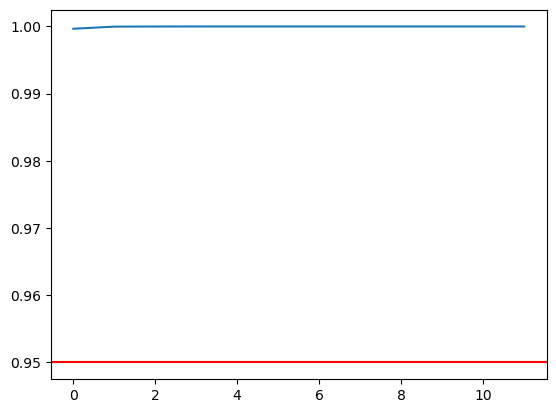

In [11]:
# Create an instance of PCA
pca = PCA(random_state= 37)

# Perform PCA on the predictors DataFrame
pca.fit(X)

# Calculate the cumulative sum of the explained variance ratio
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance with a vertical line at 95%
plt.plot(cumulative_explained_variance)
plt.axhline(y=0.95, color='r', linestyle='-')

# Find the number of components that explain at least 95% of the variance
pca_n_components = np.where(cumulative_explained_variance >= 0.95)[0][0] + 1

print(f'Number of components that explain at least 95% of the variance: {pca_n_components}')

In [12]:
# Define the number of principal components to retain
n_components = pca_n_components

# Create a pipeline with PCA and Linear Regression
pipeline = make_pipeline(PCA(n_components), LinearRegression())

# Fit the model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

Mean Squared Error: 1.5187396651660803
Root Mean Squared Error: 1.2323715613264046
R-Squared value: 0.495423187699394


In [13]:
# Get the principal components from the trained PCA model within the pipeline
principal_components = pipeline.named_steps['pca'].components_

# Calculate the squared loadings of each feature on the principal components
squared_loadings = principal_components ** 2

# Sum the squared loadings across principal components to get feature importance
feature_importance = squared_loadings.sum(axis=0)

# Get the names of the original features
feature_names = X.columns

# Create a dictionary to store feature importance with their corresponding names
feature_importance_dict = dict(zip(feature_names, feature_importance))

# Sort the features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the top N features and their importance
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, importance in sorted_features[:top_n]:
    print(f"{feature}: {importance}")

Top 3 Features:
WBI: 0.12453106496214136
MSI: 0.11427693938944712
MDATT: 0.11329738437298864


# <font color = Purple> Ensemble Methods

## <font color = darkgreen> Random Forest Regression

In [14]:
# Define the objective function for Optuna
def objective(trial):
    # Define the search space for hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 5, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    
    # Create the Random Forest model with the specified hyperparameters
    model = RandomForestRegressor(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        min_samples_split=min_samples_split, 
        min_samples_leaf=min_samples_leaf
    )
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Get the MSE of the model on the testing data
    mse = mean_squared_error(y_test, model.predict(X_test))
    
    # Return the MSE as the objective value to minimize
    return mse

# Create the Optuna study
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=37))

# Optimize the objective function
study.optimize(objective, n_trials=100)

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the Random Forest model using the best parameters
best_rf_model = RandomForestRegressor(
    n_estimators=trial.params['n_estimators'], 
    max_depth=trial.params['max_depth'], 
    min_samples_split=trial.params['min_samples_split'], 
    min_samples_leaf=trial.params['min_samples_leaf']
)

# Fit the model
best_rf_model.fit(X_train, y_train)

# Make predictions
y_pred = best_rf_model.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

[I 2024-02-25 23:45:40,304] A new study created in memory with name: no-name-29b82972-8a08-4505-8188-884f6ef4c4e6
[I 2024-02-25 23:45:40,747] Trial 0 finished with value: 1.8902186986265292 and parameters: {'n_estimators': 145, 'max_depth': 17, 'min_samples_split': 5, 'min_samples_leaf': 6}. Best is trial 0 with value: 1.8902186986265292.
[I 2024-02-25 23:45:40,933] Trial 1 finished with value: 2.0533116078820624 and parameters: {'n_estimators': 112, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 8}. Best is trial 0 with value: 1.8902186986265292.
[I 2024-02-25 23:45:41,042] Trial 2 finished with value: 2.0524960688438276 and parameters: {'n_estimators': 78, 'max_depth': 24, 'min_samples_split': 17, 'min_samples_leaf': 7}. Best is trial 0 with value: 1.8902186986265292.
[I 2024-02-25 23:45:41,212] Trial 3 finished with value: 1.4818629873615767 and parameters: {'n_estimators': 94, 'max_depth': 30, 'min_samples_split': 19, 'min_samples_leaf': 2}. Best is trial 3 with value

[I 2024-02-25 23:45:46,877] Trial 36 finished with value: 1.5073173218246552 and parameters: {'n_estimators': 55, 'max_depth': 17, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 7 with value: 1.258962700916847.
[I 2024-02-25 23:45:47,189] Trial 37 finished with value: 1.4801644279102397 and parameters: {'n_estimators': 92, 'max_depth': 14, 'min_samples_split': 14, 'min_samples_leaf': 4}. Best is trial 7 with value: 1.258962700916847.
[I 2024-02-25 23:45:47,516] Trial 38 finished with value: 1.5388791007911962 and parameters: {'n_estimators': 118, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 7 with value: 1.258962700916847.
[I 2024-02-25 23:45:47,649] Trial 39 finished with value: 2.244259439605592 and parameters: {'n_estimators': 55, 'max_depth': 20, 'min_samples_split': 16, 'min_samples_leaf': 9}. Best is trial 7 with value: 1.258962700916847.
[I 2024-02-25 23:45:47,908] Trial 40 finished with value: 1.8174876639257724 and parameters: {'

[I 2024-02-25 23:45:52,583] Trial 73 finished with value: 1.2816544003993087 and parameters: {'n_estimators': 50, 'max_depth': 8, 'min_samples_split': 18, 'min_samples_leaf': 3}. Best is trial 69 with value: 1.2374805813594973.
[I 2024-02-25 23:45:52,700] Trial 74 finished with value: 1.519109103001479 and parameters: {'n_estimators': 50, 'max_depth': 8, 'min_samples_split': 18, 'min_samples_leaf': 2}. Best is trial 69 with value: 1.2374805813594973.
[I 2024-02-25 23:45:52,817] Trial 75 finished with value: 1.6010780019025097 and parameters: {'n_estimators': 53, 'max_depth': 7, 'min_samples_split': 19, 'min_samples_leaf': 3}. Best is trial 69 with value: 1.2374805813594973.
[I 2024-02-25 23:45:52,940] Trial 76 finished with value: 1.4643413651052362 and parameters: {'n_estimators': 54, 'max_depth': 5, 'min_samples_split': 20, 'min_samples_leaf': 1}. Best is trial 69 with value: 1.2374805813594973.
[I 2024-02-25 23:45:53,065] Trial 77 finished with value: 1.5931864354190814 and paramete

Best trial:
  Value: 1.2374805813594973
  Params: 
    n_estimators: 52
    max_depth: 6
    min_samples_split: 16
    min_samples_leaf: 2
Mean Squared Error: 1.2173797525869785
Root Mean Squared Error: 1.1033493338861353
R-Squared value: 0.595545168794636


## <font color = darkblue> Variable Importance Information of RF

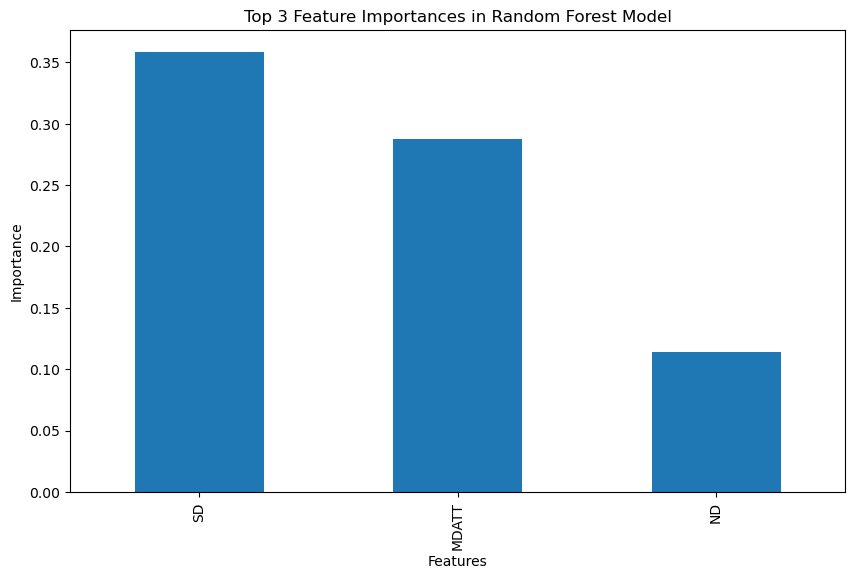

In [15]:
# Extract feature importances
feature_importances = best_rf_model.feature_importances_

# Create a series with feature names and their importance
features = pd.Series(feature_importances, index = X.columns)

# Sort the features by importance
features = features.sort_values(ascending=False)

# Select the top 3 features
top_3_features = features[:3]

# Plot the top 3 feature importances
plt.figure(figsize=(10, 6))
top_3_features.plot(kind='bar')
plt.title('Top 3 Feature Importances in Random Forest Model')
plt.ylabel('Importance')
plt.xlabel('Features')

plt.show()

## <font color = darkgreen> Gradient Boosting Regression

In [16]:
# Define the objective function for Optuna
def objective(trial):
    # Define the search space for hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 10)  # Adjust the range for max_depth
    learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
    
    # Create the Gradient Boosting model with the specified hyperparameters
    model = GradientBoostingRegressor(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        learning_rate=learning_rate  # Pass learning_rate to the model
    )
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Get the MSE of the model on the testing data
    mse = mean_squared_error(y_test, model.predict(X_test))
    
    # Return the MSE as the objective value to minimize
    return mse

# Create the Optuna study
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=37))

# Optimize the objective function
study.optimize(objective, n_trials=100)

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the Gradient Boosting model using the best parameters
best_gb_model = GradientBoostingRegressor(
    n_estimators=trial.params['n_estimators'], 
    max_depth=trial.params['max_depth'], 
    learning_rate=trial.params['learning_rate']  # Pass learning_rate to the model
)

# Fit the model
best_gb_model.fit(X_train, y_train)

# Make predictions
y_pred = best_gb_model.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))


[I 2024-02-25 23:45:56,594] A new study created in memory with name: no-name-cbb1e215-907d-4dd7-87c0-434b841986b8
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-25 23:45:56,732] Trial 0 finished with value: 2.269100850610094 and parameters: {'n_estimators': 145, 'max_depth': 6, 'learning_rate': 0.027351552606144185}. Best is trial 0 with value: 2.269100850610094.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.sugges

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-25 23:45:58,048] Trial 14 finished with value: 1.6115898095579781 and parameters: {'n_estimators': 83, 'max_depth': 4, 'learning_rate': 0.07786507003788097}. Best is trial 7 with value: 1.3549864227515687.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-25 23:45:58,139] Trial 15 fi

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-25 23:46:00,260] Trial 28 finished with value: 1.4830952484979925 and parameters: {'n_estimators': 111, 'max_depth': 3, 'learning_rate': 0.07128548346090377}. Best is trial 22 with value: 1.3441734635852667.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-25 23:46:00,594] Trial 29 

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-25 23:46:02,492] Trial 42 finished with value: 1.4993306364930694 and parameters: {'n_estimators': 105, 'max_depth': 3, 'learning_rate': 0.06752965562558766}. Best is trial 35 with value: 1.3057261166309115.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-25 23:46:02,613] Trial 43 

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-25 23:46:04,506] Trial 56 finished with value: 1.8963807038246905 and parameters: {'n_estimators': 109, 'max_depth': 5, 'learning_rate': 0.06857506698753586}. Best is trial 54 with value: 1.2246521695067552.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-25 23:46:04,622] Trial 57 

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-25 23:46:06,279] Trial 70 finished with value: 1.2454470417541448 and parameters: {'n_estimators': 101, 'max_depth': 3, 'learning_rate': 0.09556723648508494}. Best is trial 62 with value: 1.216486042054565.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-25 23:46:06,404] Trial 71 f

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-25 23:46:07,832] Trial 84 finished with value: 1.2691848108489023 and parameters: {'n_estimators': 109, 'max_depth': 3, 'learning_rate': 0.09995946485816105}. Best is trial 73 with value: 1.1760242599262987.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-25 23:46:07,931] Trial 85 

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-25 23:46:09,418] Trial 98 finished with value: 1.3752831954688969 and parameters: {'n_estimators': 109, 'max_depth': 3, 'learning_rate': 0.09007112098376868}. Best is trial 92 with value: 1.1511440191899736.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-25 23:46:09,526] Trial 99 

Best trial:
  Value: 1.1511440191899736
  Params: 
    n_estimators: 97
    max_depth: 3
    learning_rate: 0.09505572051598342
Mean Squared Error: 1.182500690843071
Root Mean Squared Error: 1.0874284761965134
R-Squared value: 0.6071331757417333


In [17]:
# Get feature importances from the trained GradientBoostingRegressor model
feature_importances = best_gb_model.feature_importances_

# Get the names of the features
feature_names = X.columns

# Create a dictionary to store feature importance scores with their corresponding names
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Sort the features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the top N features and their importance scores
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, importance in sorted_features[:top_n]:
    print(f"{feature}: {importance}")


Top 3 Features:
MDATT: 0.5840739009716583
SD: 0.1120652934718275
NMDI: 0.06472606428148968


## <font color = green> XGBoost

In [18]:
### Define the objective function for Optuna
def objective(trial):
    # Define the search space for hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5, 1.0)
    
    # Create the XGBoost model with the specified hyperparameters
    model = XGBRegressor(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        learning_rate=learning_rate,
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bytree=colsample_bytree
    )
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Get the MSE of the model on the testing data
    mse = mean_squared_error(y_test, model.predict(X_test))
    
    # Return the MSE as the objective value to minimize
    return mse

# Create the Optuna study
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=37))

# Optimize the objective function
study.optimize(objective, n_trials=100)

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the XGBoost model using the best parameters
best_xgb_model = XGBRegressor(
    n_estimators=trial.params['n_estimators'], 
    max_depth=trial.params['max_depth'], 
    learning_rate=trial.params['learning_rate'],
    min_child_weight=trial.params['min_child_weight'],
    subsample=trial.params['subsample'],
    colsample_bytree=trial.params['colsample_bytree']
)

# Fit the model
best_xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = best_xgb_model.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

[I 2024-02-25 23:46:09,657] A new study created in memory with name: no-name-9150c706-6eb1-447f-8219-2171d51096a3
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

[I 2024-02-25 23:46:10,997] Trial 13 finished with value: 1.0178150380251885 and parameters: {'n_estimators': 76, 'max_depth': 5, 'learning_rate': 0.06067903358378959, 'min_child_weight': 3, 'subsample': 0.9151853458914785, 'colsample_bytree': 0.6073701519061939}. Best is trial 8 with value: 0.993587658516716.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9gr

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5, 1.0)
[I 2024-02-25 23:46:12,144] Trial 26 finished with value: 1.0415710794370183 and parameters: {'n_estimators': 99, 'max_depth': 8, 'learning_rate': 0.02903735817221088, 'min_child_weight': 3, 'subsample': 0.7773406230783672, 'colsample_bytree': 0.6885632996641661}. Best is trial 20 with value: 0.8599550186484858.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/fo

[I 2024-02-25 23:46:12,679] Trial 32 finished with value: 0.6583531897174087 and parameters: {'n_estimators': 128, 'max_depth': 6, 'learning_rate': 0.08125917777045258, 'min_child_weight': 3, 'subsample': 0.6125559114177573, 'colsample_bytree': 0.6207414036176258}. Best is trial 32 with value: 0.6583531897174087.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5, 1.0)
[I 2024-02-25 23:46:16,784] Trial 52 finished with value: 0.8482644720018861 and parameters: {'n_estimators': 130, 'max_depth': 8, 'learning_rate': 0.08524884544077337, 'min_child_weight': 2, 'subsample': 0.5755174377124226, 'colsample_bytree': 0.8418050083670594}. Best is trial 32 with value: 0.6583531897174087.
/var/folders/3h

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

[I 2024-02-25 23:46:18,411] Trial 65 finished with value: 0.8511334259695814 and parameters: {'n_estimators': 141, 'max_depth': 7, 'learning_rate': 0.09963180502890875, 'min_child_weight': 4, 'subsample': 0.6315842833233122, 'colsample_bytree': 0.7521062989824553}. Best is trial 55 with value: 0.6270041106851297.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

[I 2024-02-25 23:46:20,315] Trial 78 finished with value: 1.282475283670786 and parameters: {'n_estimators': 73, 'max_depth': 10, 'learning_rate': 0.0939331426765461, 'min_child_weight': 7, 'subsample': 0.6344468481865707, 'colsample_bytree': 0.7600225280688574}. Best is trial 55 with value: 0.6270041106851297.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9g

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

[I 2024-02-25 23:46:21,849] Trial 91 finished with value: 0.728993783193976 and parameters: {'n_estimators': 145, 'max_depth': 9, 'learning_rate': 0.09336568775907968, 'min_child_weight': 3, 'subsample': 0.6278235309023549, 'colsample_bytree': 0.7788195054620556}. Best is trial 55 with value: 0.6270041106851297.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_46673/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

Best trial:
  Value: 0.6270041106851297
  Params: 
    n_estimators: 137
    max_depth: 8
    learning_rate: 0.09996948237852128
    min_child_weight: 3
    subsample: 0.5913576587246031
    colsample_bytree: 0.7639548683150814
Mean Squared Error: 0.6270041106851297
Root Mean Squared Error: 0.7918359114646984
R-Squared value: 0.7916879747561723


In [19]:
# Get feature importances from the trained XGBoost model
feature_importances = best_xgb_model.feature_importances_

# Get the names of the features
feature_names = X.columns

# Create a dictionary to store feature importance scores with their corresponding names
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Sort the features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the top N features and their importance scores
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, importance in sorted_features[:top_n]:
    print(f"{feature}: {importance}")

Top 3 Features:
MDATT: 0.21317251026630402
ND: 0.20059646666049957
SD: 0.17458118498325348
